In [1]:
# The MASER code for computing the visibility of polarised radio emission induced by a planet on its host star when in a sub-Alfvénic orbit.
# 
# See full details in Kavanagh & Vedantham (2023).
# 
# Version 1.0

import numpy as np
import jax.numpy as jnp

import matplotlib.pyplot as plt

from jax import jit, vmap, grad, random

from maser import maser as rob_maser

step = lambda x: jnp.heaviside(x, 1.0)

In [2]:

# Constants
Msun = 1.989e33
Rsun = 6.955e10
G = 6.674e-8
rad_per_deg = jnp.pi / 180
sec_per_day = 86400

# Max loop size (Rstar)
Lmax = 100

# Tolerance for solver
tol = 1e-2

# Zero vector
zero_vec = jnp.array([0.0, 0.0, 0.0])

# Inputs:
# - M_s:     Stellar mass (solar masses)
# - R_s:     Stellar radius (solar radii)
# - P_s:     Stellar rotation period (days)
# - i_s:     Stellar inclination (degrees)
# - B_s:     Dipole field strength at magnetic poles (Gauss)
# - beta:    Magnetic obliquity (degrees)
# - phi_s0:  Rotation phase at time zero (0 - 1)
# - a:       Orbital distance (stellar radii)
# - i_p:     Orbital inclination (degrees)
# - lam:     Projected spin-orbit angle (degrees)
# - phi_p0:  Orbital phase at time zero (0 - 1)
# - f:       Observing frequency (MHz)
# - alpha:   Cone opening angle (degrees)
# - dalpha:  Cone thickness (degrees)
# - times:   Times to compute the visibility at (days)
# 
# The function returns two arrays of boolean values, which infer if emission is visible from the Northern (vis_N) and Southern (vis_S) magnetic hemispheres at each element of the times array.



In [16]:

def get_rf(B_f,B_s,L):

	# Initialise solver
	r_i = 1

	for j in range(10):
		B_i = B_s * (1 - 0.75 / L) ** 0.5

	# Loop until frequency difference is less than tolerance set
	
		# converged =  step(jnp.abs(1 - B_i / B_f) -tol)

		F_i = (B_f / B_s) ** 2 * r_i ** 6. + 0.75 * r_i / L - 1
		dF_i = 6 * (B_f / B_s) ** 2 * r_i ** 5. + 0.75 / L
		r_i = r_i - F_i / dF_i
		B_i = B_s * r_i ** -3. * (1 - 0.75 * r_i / L) ** 0.5

	return r_i

def vis_t(t, P_s, B_s, beta, phi_s0, a, i_p, phi_p0, f, alpha, dalpha,
								x, y, n_s, z_s, y1, z1,P_p):
	##################################################
	# Compute vectors
	##################################################

	# Rotation phase (rad)
	phi_s = 2 * jnp.pi * (phi_s0 + t / P_s)

	# Planet orbital phase (rad)
	phi_p = 2 * jnp.pi * (phi_p0	+ t / P_p)

	# Stellar coordinates
	x_s = jnp.cos(phi_s) * n_s + jnp.sin(phi_s) * y

	# Magnetic pole
	z_B = jnp.sin(beta) * x_s + jnp.cos(beta) * z_s

	# Planet coordinates
	n_p = jnp.sin(i_p) * x - jnp.cos(i_p) * z1
	x_p = jnp.sin(phi_p) * y1 + jnp.cos(phi_p) * n_p

	# Magnetic latitude of planet
	cos_theta_p = jnp.sum(x_p * z_B)
	sin_theta_p = (1 - cos_theta_p ** 2) ** 0.5

	# Loop size
	L = a / (sin_theta_p) ** 2 # fudge the infinity

	# Min and max frequency on field line
	f_min = 1.4 * B_s * L ** -3.
	f_max = 2.8 * B_s * (1 - 0.75 / L) ** 0.5

	# Planet frequency (MHz)
	f_p = 2.8 * B_s * (a ** -3.) * (1 - 0.75 * a / L) ** 0.5

	# Skip time if emission cannot occur at frequency f on the field line
	can_occur_on_line = step(f-f_min) * step(f_max-f) * step(Lmax-L) * step(f-f_p)
	# if ((f > f_max) | (f < f_min)) | ((L > Lmax) & (f_p > f)): 
	# 	return 0., 0.

	# Magnetic equator
	# if L == jnp.inf: x_B = zero_vec # this never happens
	x_B = x_p / sin_theta_p - (cos_theta_p / sin_theta_p) * z_B

	##################################################
	# Solve for radius of emitting point
	##################################################

	# Field strength of emitting point
	B_f = f / 2.8

		
	r_f = get_rf(B_f,B_s,L)
	# print(converged)

	##################################################
	# Visibility
	##################################################

	# Compute latitude of emission point in Northern hemisphere
	sin_theta_f = (r_f / L) ** 0.5
	cos_theta_f = (1 - sin_theta_f ** 2) ** 0.5

	# Cone components in Northern hemisphere in terms of x_B and z_B
	c_x = 3 * sin_theta_f * cos_theta_f / (1 + 3 * cos_theta_f ** 2) ** 0.5
	c_z = (3 * cos_theta_f ** 2 - 1) / (1 + 3 * cos_theta_f ** 2) ** 0.5

	# Check if emission generated in Northern hemisphere
	occurs_in_north = jnp.max(jnp.array([step(f-f_p)*step(cos_theta_p), step(-cos_theta_p)*step(Lmax-L)]))

	# Cone axis
	c_N = c_x * x_B + c_z * z_B

	# Angle between cone and line of sight (rad)
	gamma_N = jnp.arccos(c_N[0])

	# Visibility
	occurs_in_north *= step(gamma_N - (alpha - dalpha / 2)) * step(alpha + dalpha / 2 - gamma_N)	

	vis_N = can_occur_on_line*occurs_in_north

	# Check if emission generated in Southern hemisphere
	occurs_in_south = jnp.max(jnp.array([step(f-f_p)*step(-cos_theta_p), step(cos_theta_p)*step(Lmax-L)]))

	# Cone axis
	c_S = c_x * x_B - c_z * z_B

	# Angle between cone and line of sight (rad)
	gamma_S = jnp.arccos(c_S[0])

		# Visibility
	occurs_in_south *= step(gamma_S - (alpha - dalpha / 2)) * step(alpha + dalpha / 2 - gamma_S)

	vis_S = can_occur_on_line*occurs_in_south

	return vis_N, vis_S		

# Line of sight axes
x = jnp.array([1, 0, 0])
y = jnp.array([0, 1, 0])
z = jnp.array([0, 0, 1])

def maser(M_s, R_s, P_s, i_s, B_s, beta, phi_s0, a, i_p, lam, phi_p0, f, alpha, dalpha, times):

	# Skip sample if emission at frequency f is not possible
	frequency_possible = step(2.8*B_s-f)

	# Planet orbital period (days)
	P_p = 2 * jnp.pi * ((a * R_s * Rsun) ** 3 / (G * M_s * Msun)) ** 0.5 / sec_per_day

	# Angles to rad
	i_s *= rad_per_deg
	beta *= rad_per_deg
	i_p *= rad_per_deg
	lam *= rad_per_deg
	alpha *= rad_per_deg
	dalpha *= rad_per_deg

	# Trig terms
	sin_i_s = jnp.sin(i_s)
	cos_i_s = jnp.cos(i_s)
	sin_lam = jnp.sin(lam)
	cos_lam = jnp.cos(lam)

	# Stellar coordinates
	z_s = cos_i_s * x + sin_i_s * z
	n_s = sin_i_s * x - cos_i_s * z

	# Plane of sky vectors for planet
	y1 = cos_lam * y - sin_lam * z
	z1 = sin_lam * y + cos_lam * z


	##################################################
	# Time loop
	##################################################

	vis_N, vis_S = vmap(lambda t: vis_t(t, P_s, B_s, beta, phi_s0, a, i_p, phi_p0, f, alpha, dalpha,
								x, y, n_s, z_s, y1, z1,P_p))(times)

	return frequency_possible*jnp.array([vis_N, vis_S])

In [17]:
# Defining variables 
# Stuff for MASER

# Stellar parameters
M_s = 0.5 # Star mass (solar masses) 
R_s = 0.75 # Star radius (solar radii) 
P_s = 4.86 # Star rotation period (days) 
i_s = 90 # Star inclination of the rotation axis relative to the line of sight (degrees) 
B_s = 430 # Star dipole field strength at the magnetic poles (Gauss) 
beta = 20 # Star magnetic obliquity (degrees)
phi_s0 = 0.2 # Star rotation phase at times = 0 (0 – 1)

# Planet parameters
a = 10 # Planet orbital distance (stellar radii) #### REFERENCE 
i_p = 89.18 # Planet inclination of the orbital axis relative to the line of sight (degrees)
lam = 0 # Planet projected spin-orbit angle (degrees) 
phi_p0 = 0.6 # Planet orbital phase at times = 0 (0 – 1) 

# Emission parameters
f = 10 # Emission observing frequency (MHz) 
alpha = 75 # Emission cone opening angle (degrees) 
dalpha = 5 # Emission cone thickness (degrees)

# Extra stuff 
P_p = 8.4630351 # AU Mic b period (days)

In [84]:
times = np.linspace(0, 730, 80000) # Array of observation times to compute (days) - running for 2 years


In [85]:
%%timeit

# Calling MASER
visibility_North, visibility_South = maser(M_s, R_s, P_s, i_s, B_s, beta, phi_s0, a, i_p, lam, phi_p0, f, alpha, dalpha, times)


344 ms ± 51.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [86]:
compiled_maser = jit(maser)
# do once to jit
visibility_North, visibility_South = compiled_maser(M_s, R_s, P_s, i_s, B_s, beta, phi_s0, a, i_p, lam, phi_p0, f, alpha, dalpha, times)


In [87]:
%%timeit

# Calling MASER
visibility_North, visibility_South = compiled_maser(M_s, R_s, P_s, i_s, B_s, beta, phi_s0, a, i_p, lam, phi_p0, f, alpha, dalpha, times)


12.1 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [88]:
%%timeit 

rob_visibility_North, rob_visibility_South = rob_maser(M_s, R_s, P_s, i_s, B_s, beta, phi_s0, a, i_p, lam, phi_p0, f, alpha, dalpha, times)


5.32 s ± 180 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [91]:
rob_visibility_North, rob_visibility_South = rob_maser(M_s, R_s, P_s, i_s, B_s, beta, phi_s0, a, i_p, lam, phi_p0, f, alpha, dalpha, times)

Text(0, 0.5, 'Visibility')

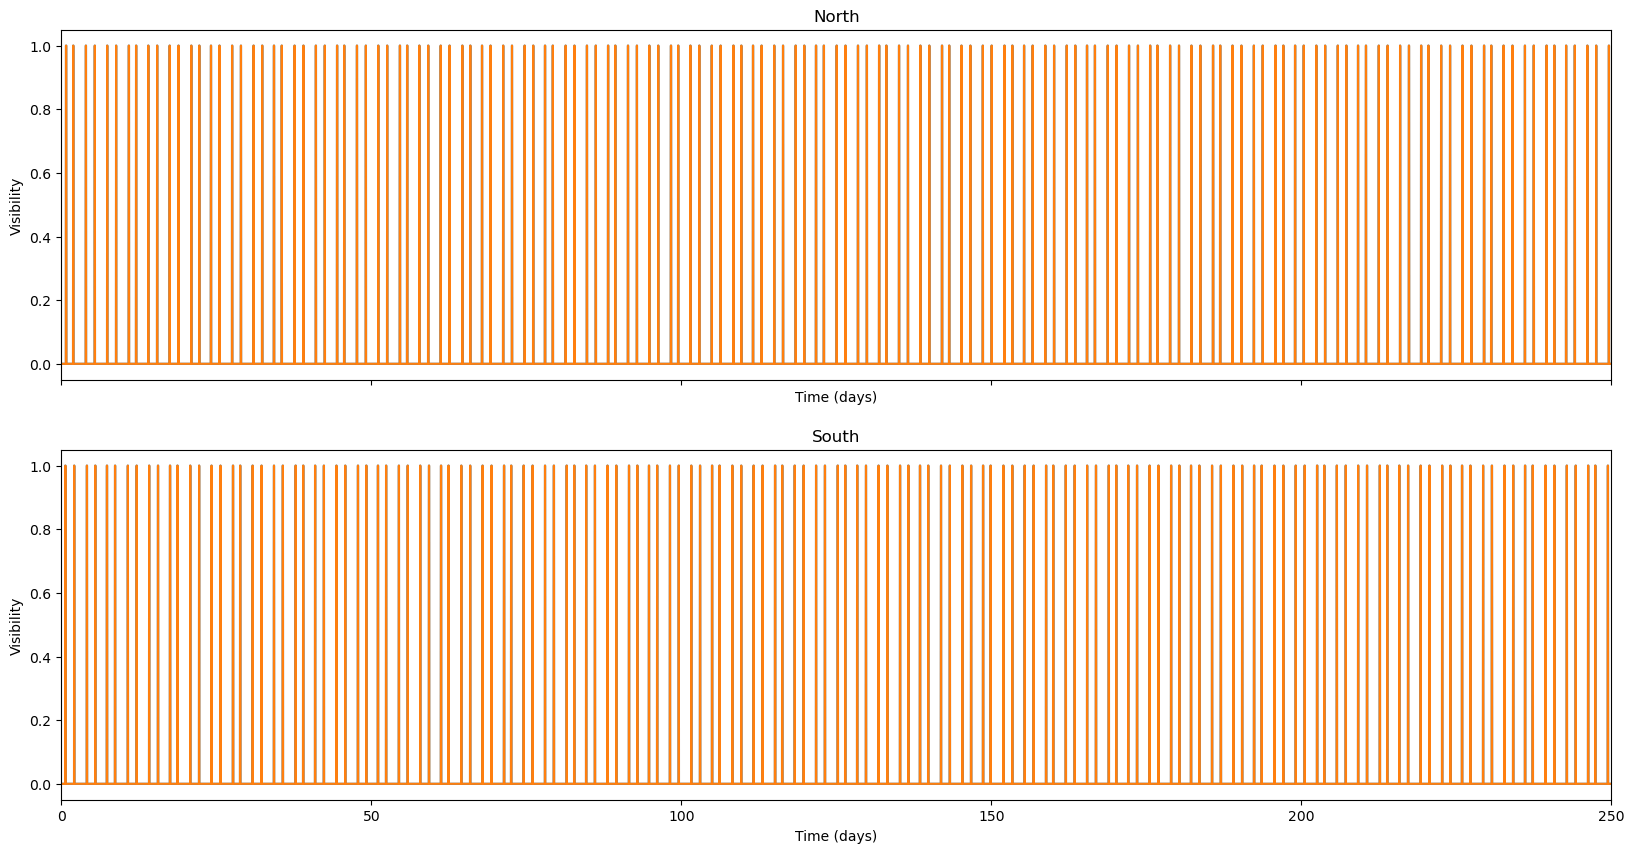

In [92]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(20,10))

ax1.plot(times,visibility_North)
ax1.plot(times,rob_visibility_North)
# plt.plot(times,visibility_South)
ax1.set_xlim(0,250)
ax1.set_title('North')
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Visibility')

ax2.plot(times,visibility_South)
ax2.plot(times,rob_visibility_South)
# plt.plot(times,visibility_South)
ax2.set_xlim(0,250)
ax2.set_title('South')
ax2.set_xlabel('Time (days)')
ax2.set_ylabel('Visibility')

Text(0.5, 1.0, 'South: Rob - Jax differences 14 / 80000 ')

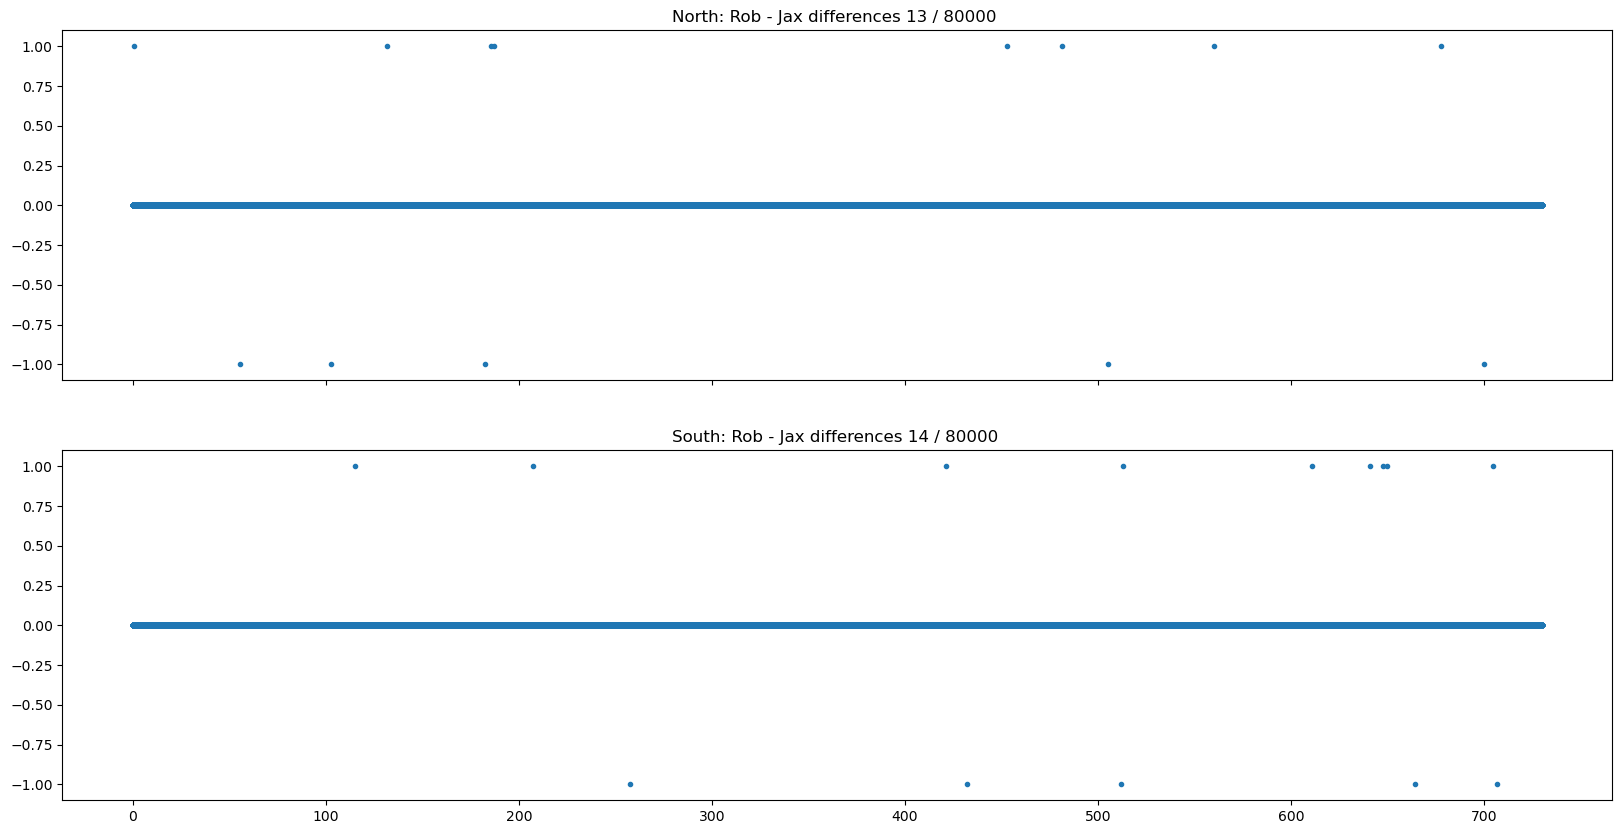

In [93]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(20,10))


ax1.plot(times,rob_visibility_North-visibility_North,'.')
# plt.xlim(230,232)
ax1.set_title('North: Rob - Jax differences %d / %d ' % (jnp.sum(np.abs(rob_visibility_North-visibility_North)), len(rob_visibility_North)) )

ax2.plot(times,rob_visibility_South-visibility_South,'.')
ax2.set_title('South: Rob - Jax differences %d / %d ' % (jnp.sum(np.abs(rob_visibility_South-visibility_South)), len(rob_visibility_South)) )